In [2]:
import pandas as pd
import sqlalchemy
from sqlalchemy.orm import sessionmaker
import requests
import json
import sqlite3
import datetime
import os
import pickle
import google_auth_oauthlib.flow
import googleapiclient.discovery
import googleapiclient.errors
from google.auth.transport.requests import Request




In [3]:
DATABASE_LOCATION="sqlite:///played_video.sqlite"
USER_ID="518849527323-n31vd6jl288oa6a4c53rk8te454epcai.apps.googleusercontent.com"
scopes = ["https://www.googleapis.com/auth/youtube.readonly"]

In [3]:
pip install google-api-python-client


Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install google-authl-oauthlib

# Projet API Youtube

## Processus ETL

In [4]:
def check_credentials(cred,client_secrets_file):
    credentials=cred
    if os.path.exists('token.pickle'):
        print('Loading Credentials From File...')
        with open('token.pickle', 'rb') as token:
            credentials = pickle.load(token)
            
    if not credentials or not credentials.valid:
        
        if credentials and credentials.expired and credentials.refresh_token:
            print('Refreshing Access Token...')
            credentials.refresh(Request())
        else :
        
            flow = google_auth_oauthlib.flow.InstalledAppFlow.from_client_secrets_file(
            client_secrets_file, scopes)
            credentials = flow.run_console()
            print("hello")
            with open('token.pickle', 'wb') as f:
                print('Saving Credentials for Future Use...')
                pickle.dump(credentials, f)
  
    return credentials

In [5]:
def check_valid_data(data) :
    if(pd.Series(data["New_ID"]).is_unique) :
        pass
    else :
        raise Exception("primary key not unique")
        
    if(data.isnull().values.any()):
        raise Exception("Nulls values")
        
    return True

In [6]:
def histo():
    MyRange= [i for i in range(5,155,10)]
    plt.figure(figsize=(9,9),dpi=80)
    plt.bar(MyRange,liste_probleme_résolus,width=9,edgecolor="black",color="yellow")
    plt.xlabel("Therehold en minutes",fontsize=15)
    plt.ylabel("Nombre de retards résolus",fontsize=15)
    plt.title("Nombre de retards supprimés en fonction du therehold fixé",fontsize=18)
    plt.xticks(MyRange)

Loading Credentials From File...
Refreshing Access Token...


les données sont valides


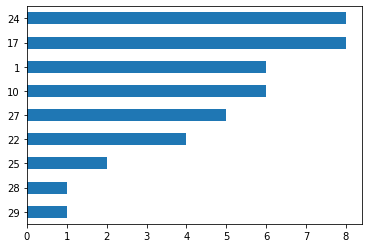

In [17]:


# Sample Python code for youtube.videos.list
# See instructions for running these code samples locally:
# https://developers.google.com/explorer-help/guides/code_samples#python

import os
import pickle
import google_auth_oauthlib.flow
import googleapiclient.discovery
import googleapiclient.errors



def main():
    # Disable OAuthlib's HTTPS verification when running locally.
    # *DO NOT* leave this option enabled in production.
    os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"
    credentials=None
    api_service_name = "youtube"
    api_version = "v3"
    client_secrets_file = "code_secret_client.json"

    # Get credentials and create an API client

    credentials = check_credentials(credentials,client_secrets_file)
    youtube = googleapiclient.discovery.build(
        api_service_name, api_version, credentials=credentials)

    request = youtube.videos().list(
        part="snippet,contentDetails,statistics",
        myRating="like",
        maxResults="50"
    )
    response = request.execute()
    liste = response['items'] 
    video_id = list()
    video_title = list()
    video_published_at = list()
    video_viewed_at = list()
    categorie_id = list()
    for video in liste : # on parcours une liste
  
        for d,v in video['snippet'].items() : # on parcours un dictionnaire  
            if( d == 'title'):
                video_title.append(v)
            if( d == 'publishedAt') :
                video_published_at.append(v)
            if( d == 'categoryId') :
                categorie_id.append(v)
           
            
    dict_videos={
        
        "title" : video_title,
        "publishedAt" :  video_published_at,
        "categoryId" :  categorie_id     
    }
    
    video_frame=pd.DataFrame(dict_videos)
    video_frame.insert(0, 'New_ID', range(0,len(video_frame)))
    
    if(check_valid_data(video_frame)):
        print("\n")
        print("les données sont valides")
   
    #Load
    engine = sqlalchemy.create_engine(DATABASE_LOCATION)
    con = sqlite3.connect("played_video.sqlite")
    curs = con.cursor()
 
    video_frame.to_sql("my_played_video",engine,index=False,if_exists='replace')
    sql_query="""
    select * from my_played_video;"""
    print(curs.execute(sql_query))
    con.close()
    
    video_frame.categoryId.value_counts().sort_values().plot(kind = 'barh')
if __name__ == "__main__":
    main()